# Lip Reading Project 
@author : Hatem Trigui 

In [16]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import os

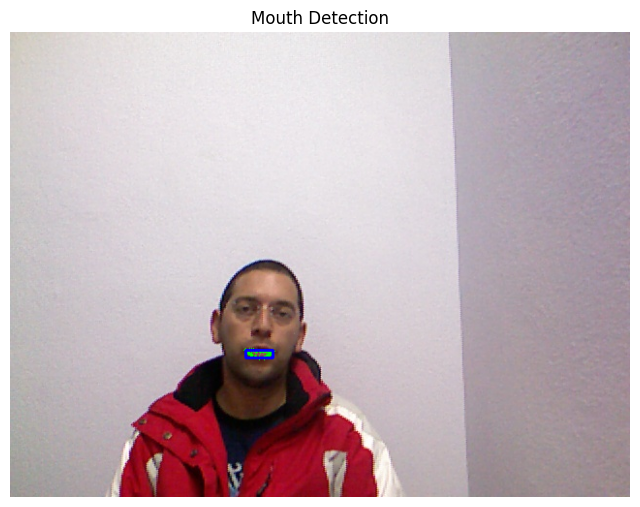

In [1]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

def visualize_mouth_detection(image_path):
    # Load and prepare the image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detect facial landmarks
    results = face_mesh.process(rgb_image)
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Define mouth landmarks indices
            mouth_landmarks_indices = [
                61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308,
                324, 318, 402, 317, 14, 87, 178, 88, 95
            ]
            h, w, _ = rgb_image.shape
            
            # Extract and draw the mouth landmarks
            for idx in mouth_landmarks_indices:
                x = int(face_landmarks.landmark[idx].x * w)
                y = int(face_landmarks.landmark[idx].y * h)
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            
            # Draw the bounding box for the mouth region
            mouth_coords = [(int(face_landmarks.landmark[idx].x * w), int(face_landmarks.landmark[idx].y * h)) for idx in mouth_landmarks_indices]
            x_min = min([coord[0] for coord in mouth_coords])
            y_min = min([coord[1] for coord in mouth_coords])
            x_max = max([coord[0] for coord in mouth_coords])
            y_max = max([coord[1] for coord in mouth_coords])
            
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    
    # Display the image with mouth detection
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Mouth Detection")
    plt.show()

# Test the function with a sample image
sample_image_path = "C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one\\M07\\phrases\\09\\10\\color_010.jpg" 
visualize_mouth_detection(sample_image_path)

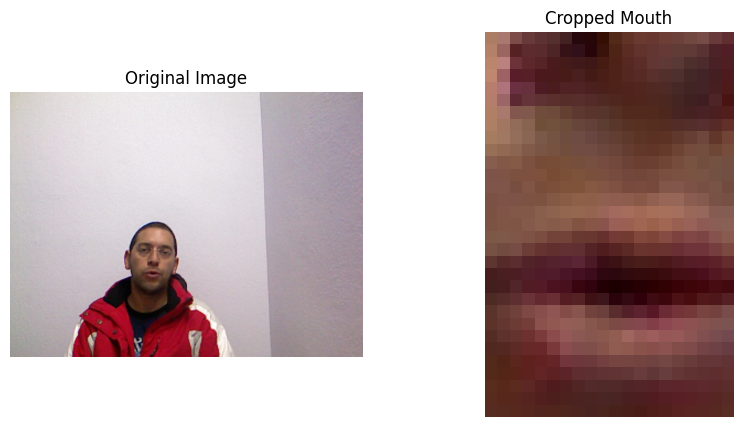

In [2]:


# Initialize Mediapipe Face Mesh model
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

def detect_and_crop_mouth(image):
    # Convert image to RGB (Mediapipe expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process the image to detect facial landmarks
    results = face_mesh.process(image_rgb)
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # The mouth landmarks indices from Mediapipe face mesh
            mouth_indices = list(range(78, 88)) + list(range(310, 319))  # These are the mouth landmarks
            
            # Get the coordinates of the mouth landmarks
            mouth_points = [(int(face_landmarks.landmark[i].x * image.shape[1]),
                             int(face_landmarks.landmark[i].y * image.shape[0])) for i in mouth_indices]
            
            # Get the bounding box for the mouth region
            x_min = min([point[0] for point in mouth_points])
            x_max = max([point[0] for point in mouth_points])
            y_min = min([point[1] for point in mouth_points])
            y_max = max([point[1] for point in mouth_points])
            
            # Ensure the bounding box is within the image bounds
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image.shape[1], x_max)
            y_max = min(image.shape[0], y_max)
            
            # Crop the mouth region using the bounding box
            cropped_mouth = image[y_min:y_max, x_min:x_max]
            return cropped_mouth
    return None

def visualize_mouth_detection(image_path):
    # Read image
    image = cv2.imread(image_path)
    
    # Detect and crop the mouth
    cropped_mouth = detect_and_crop_mouth(image)
    
    if cropped_mouth is not None:
        # Display the original image and cropped mouth side by side
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Original Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(cropped_mouth, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Cropped Mouth")
        
        plt.show()
    else:
        print("Mouth not detected in the image.")

# Test the function on an example image
visualize_mouth_detection("C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one\\M07\\phrases\\09\\10\\color_010.jpg")


In [3]:
def preprocess_mouth_image(cropped_mouth, output_size=(64, 64)):
    if cropped_mouth is not None:
        # Resize the image
        resized_image = cv2.resize(cropped_mouth, output_size)
        # Convert to grayscale
        grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        # Normalize pixel values
        normalized_image = grayscale_image / 255.0
        return normalized_image
    return None


In [4]:
# Word and Phrase Mappings
WORD_LABELS = {
    1: "Hegin",
    2: "Choose",
    3: "Connection",
    4: "Navigation",
    5: "Next",
    6: "Previous",
    7: "Start",
    8: "Stop",
    9: "Hello",
    10: "Well"
}

PHRASE_LABELS = {
    1: "Stop navigation.",
    2: "Excuse me.",
    3: "I am sorry.",
    4: "Thank you.",
    5: "Good bye.",
    6: "I love this game.",
    7: "Nice to meet you.",
    8: "You are welcome.",
    9: "How are you?",
    10: "Have a good time."
}


In [5]:
def create_dataset(root_folder, word_labels, phrase_labels, output_size=(64, 64)):
    X = []  # Features (sequences of images)
    y = []  # Labels (word/phrase IDs)
    
    # Ensure labels keys match folder IDs
    word_labels = {f"{int(k):02}": v for k, v in word_labels.items()}
    phrase_labels = {f"{int(k):02}": v for k, v in phrase_labels.items()}
    
    for person_id in os.listdir(root_folder):
        person_path = os.path.join(root_folder, person_id)
        if os.path.isdir(person_path):
            for data_type in ["words", "phrases"]:
                type_path = os.path.join(person_path, data_type)
                labels_dict = word_labels if data_type == "words" else phrase_labels
                
                if os.path.isdir(type_path):
                    for label_id in os.listdir(type_path):
                        label_path = os.path.join(type_path, label_id)
                        if os.path.isdir(label_path):
                            for instance_id in os.listdir(label_path):
                                instance_path = os.path.join(label_path, instance_id)
                                sequence = []
                                
                                for file in sorted(os.listdir(instance_path)):
                                    if file.endswith(".jpg"):
                                        file_path = os.path.join(instance_path, file)
                                        image = cv2.imread(file_path)
                                        cropped_mouth = detect_and_crop_mouth(image)
                                        preprocessed_image = preprocess_mouth_image(cropped_mouth, output_size)
                                        if preprocessed_image is not None:
                                            sequence.append(preprocessed_image)
                                
                                if sequence:
                                    if label_id in labels_dict:
                                        X.append(sequence)
                                        y.append(labels_dict[label_id])
                                    else:
                                        print(f"Warning: No label found for label ID: {label_id}. Skipping.")
    
    return X, y


In [7]:

X, y = create_dataset(
    root_folder="C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one", 
    word_labels=WORD_LABELS, 
    phrase_labels=PHRASE_LABELS
)
print(f"Dataset created with {len(X)} sequences.")


Dataset created with 3000 sequences.


In [8]:
print(f"Number of sequences: {len(X)}")
print(f"Number of labels: {len(y)}")
print(f"Shape of the first sequence: {len(X[0])} frames of size {X[0][0].shape}")
print(f"First 5 labels: {y[:5]}")

Number of sequences: 3000
Number of labels: 3000
Shape of the first sequence: 10 frames of size (64, 64)
First 5 labels: ['Hegin', 'Hegin', 'Hegin', 'Hegin', 'Hegin']


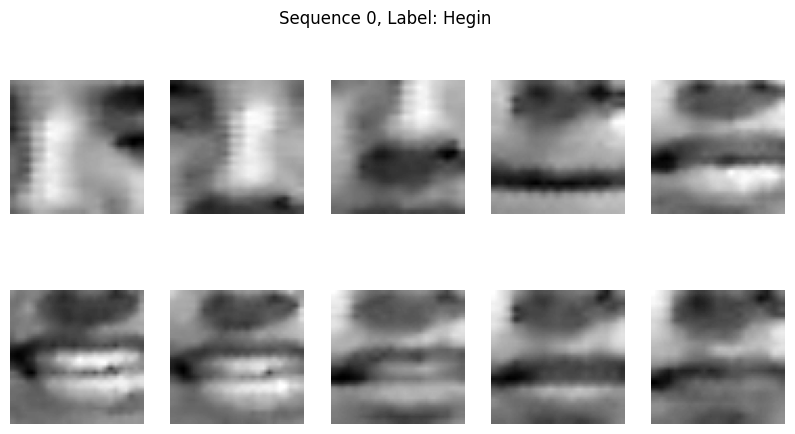

In [15]:
sequence_index = 0
frames = X[sequence_index]

plt.figure(figsize=(10, 5))
for i, frame in enumerate(frames[:10]):  # Show first 10 frames
    plt.subplot(2, 5, i + 1)
    plt.imshow(frame, cmap="gray")
    plt.axis("off")
plt.suptitle(f"Sequence {sequence_index}, Label: {y[sequence_index]}")
plt.show()
